In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

Found 2152 files belonging to 3 classes.


In [4]:
# Data splitting
train_size = 0.8
val_size = 0.1
test_size = 0.1

In [5]:
train_ds = dataset.take(int(len(dataset) * train_size))
remaining_ds = dataset.skip(int(len(dataset) * train_size))
val_ds = remaining_ds.take(int(len(remaining_ds) * (val_size / (val_size + test_size))))
test_ds = remaining_ds.skip(int(len(remaining_ds) * (val_size / (val_size + test_size))))


In [6]:
# Data preprocessing
resize_and_rescale = preprocessing.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.2),
])

In [7]:
# Apply preprocessing and data augmentation
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))

test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [8]:
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
# Load EfficientNet model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                   include_top=False,
                                                   weights='imagenet')
base_model.trainable = False



16705208/16705208 [==============================] - 3s 0us/step


In [10]:
# Build the model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50


54/54 [==============================] - 35s 554ms/step - loss: 0.9390 - accuracy: 0.4456 - val_loss: 0.9331 - val_accuracy: 0.4554
Epoch 2/50
54/54 [==============================] - 27s 503ms/step - loss: 0.9215 - accuracy: 0.4514 - val_loss: 0.9137 - val_accuracy: 0.4554
Epoch 3/50
54/54 [==============================] - 26s 479ms/step - loss: 0.9208 - accuracy: 0.4485 - val_loss: 0.9110 - val_accuracy: 0.4554
Epoch 4/50
54/54 [==============================] - 26s 480ms/step - loss: 0.9159 - accuracy: 0.4497 - val_loss: 0.9089 - val_accuracy: 0.4554
Epoch 5/50
54/54 [==============================] - 26s 481ms/step - loss: 0.9159 - accuracy: 0.4589 - val_loss: 0.9085 - val_accuracy: 0.4554
Epoch 6/50
54/54 [==============================] - 26s 480ms/step - loss: 0.9153 - accuracy: 0.4670 - val_loss: 0.9087 - val_accuracy: 0.4554
Epoch 7/50
54/54 [==============================] - 26s 481ms/step - loss: 0.9157 - accuracy: 0.4520 - val_loss: 0.9082 - val_accuracy: 0.45

In [13]:
# Evaluate the model
scores = model.evaluate(test_ds)

7/7 [==============================] - 3s 385ms/step - loss: 0.8854 - accuracy: 0.5000


7/7 [==============================] - 3s 375ms/step


C:\Users\sohel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sohel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sohel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


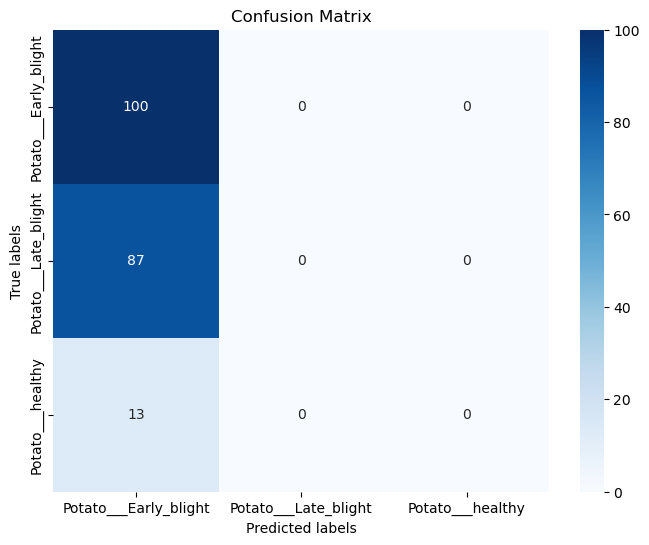

In [17]:
# Confusion Matrix
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=-1)
conf_mat = confusion_matrix(y_true, y_pred)
# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

                       precision    recall  f1-score   support

Potato___Early_blight       0.50      1.00      0.67       100
 Potato___Late_blight       0.00      0.00      0.00        87
     Potato___healthy       0.00      0.00      0.00        13

             accuracy                           0.50       200
            macro avg       0.17      0.33      0.22       200
         weighted avg       0.25      0.50      0.33       200



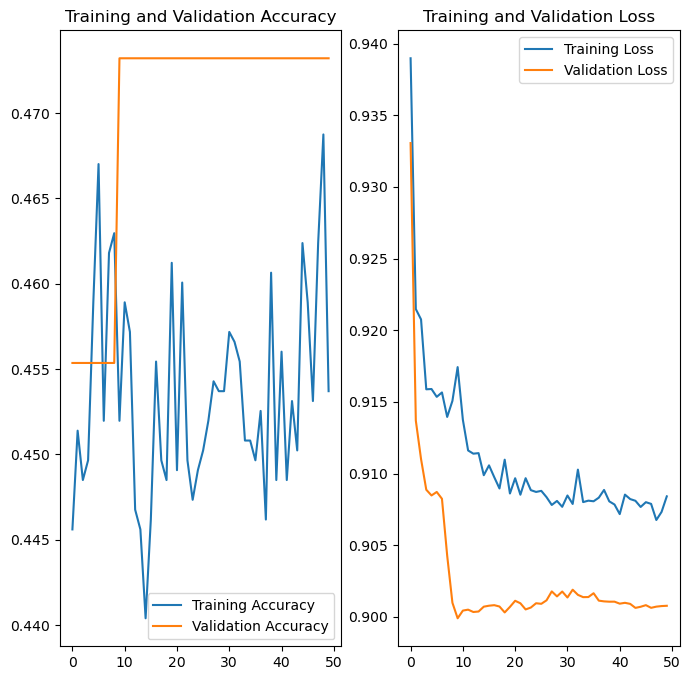

In [18]:
# Display Classification Report
print(class_report)

# Plot Training History
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
